# ACDC Unet LV binary segmentation

In [1]:
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch import nn
import sklearn
#from torchvision import transforms
from apex import amp
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os
import numpy as np
import nibabel as nib
import segmentation_models_pytorch as smp
import torch
from torch.utils import data
from torch import nn 
import torchvision.transforms.functional as TF
import glob

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [4]:
path = '/home/euloo/Documents/datasets/acdc/'

In [5]:
!ls -lah /home/euloo/Documents/datasets/acdc/patient002/

total 18M
drwxr-xr-x   2 euloo euloo 4.0K Jun 12  2017 .
drwx------ 104 euloo euloo 4.0K Jul  6 21:58 ..
-rw-r--r--   1 euloo euloo   63 Mar 21  2017 Info.cfg
-rwxrwx---   1 euloo euloo  17M Mar 21  2017 patient002_4d.nii.gz
-rw-r--r--   1 euloo euloo 7.1K Jun  8  2017 patient002_frame01_gt.nii.gz
-rw-r--r--   1 euloo euloo 599K Mar 21  2017 patient002_frame01.nii.gz
-rw-r--r--   1 euloo euloo 6.4K Jun  8  2017 patient002_frame12_gt.nii.gz
-rw-r--r--   1 euloo euloo 600K Mar 21  2017 patient002_frame12.nii.gz


In [6]:
img = nib.load('/home/euloo/Documents/datasets/acdc/patient008/patient008_frame01.nii.gz')
msk = nib.load('/home/euloo/Documents/datasets/acdc/patient008/patient008_frame01_gt.nii.gz')
img12 = nib.load('/home/euloo/Documents/datasets/acdc/patient008/patient008_frame13.nii.gz')
msk12 = nib.load('/home/euloo/Documents/datasets/acdc/patient008/patient008_frame13_gt.nii.gz')

In [7]:
img.shape, msk.shape

((200, 256, 10), (200, 256, 10))

In [8]:
img = img.get_fdata()
msk = msk.get_fdata()
img12 = img12.get_fdata()
msk12 = msk12.get_fdata()

In [9]:
img.shape

(200, 256, 10)

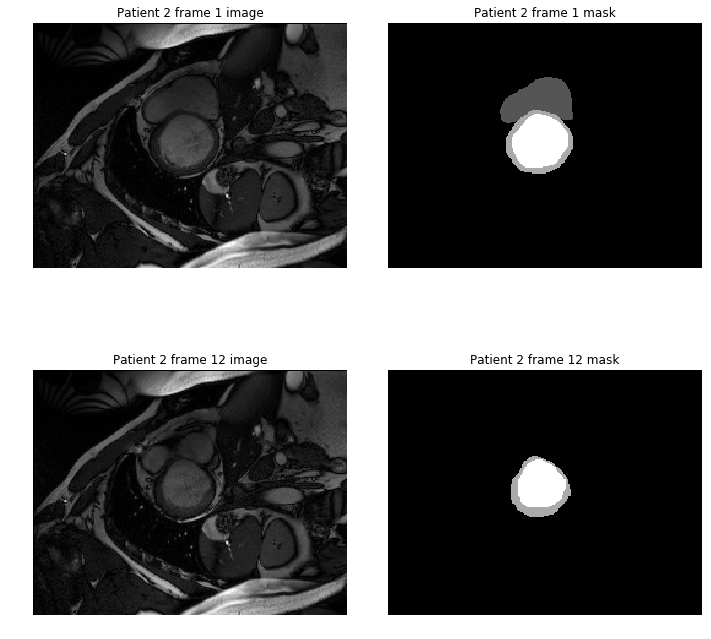

In [10]:
plt.figure(figsize=(10,10))

plt.subplot(221)
plt.title('Patient 2 frame 1 image')
plt.imshow(img[:,:,0], cmap = 'gray')
plt.axis('off')
plt.subplot(222)
plt.title('Patient 2 frame 1 mask')
plt.imshow(msk[:,:,0], cmap = 'gray')
plt.axis('off')
plt.subplot(223)
plt.title('Patient 2 frame 12 image')
plt.imshow(img12[:,:,0], cmap = 'gray')
plt.axis('off')
plt.subplot(224)
plt.title('Patient 2 frame 12 mask')
plt.imshow(msk12[:,:,0], cmap = 'gray')
plt.axis('off')
plt.tight_layout()

In [11]:
!ls /home/euloo/Documents/datasets/acdc/

images		     patient016  patient034  patient052  patient070  patient088
masks		     patient017  patient035  patient053  patient071  patient089
patient001	     patient018  patient036  patient054  patient072  patient090
patient001.Info.cfg  patient019  patient037  patient055  patient073  patient091
patient002	     patient020  patient038  patient056  patient074  patient092
patient003	     patient021  patient039  patient057  patient075  patient093
patient004	     patient022  patient040  patient058  patient076  patient094
patient005	     patient023  patient041  patient059  patient077  patient095
patient006	     patient024  patient042  patient060  patient078  patient096
patient007	     patient025  patient043  patient061  patient079  patient097
patient008	     patient026  patient044  patient062  patient080  patient098
patient009	     patient027  patient045  patient063  patient081  patient099
patient010	     patient028  patient046  patient064  patient082  patient100
patient011	     patient029 

In [217]:
bashCommand = "ls -R | grep -v 'gt.nii.gz$'"
import subprocess
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()

In [222]:
ls -R /home/euloo/Documents/datasets/acdc/patient043 | grep -v 'gt.nii.gz$'

/home/euloo/Documents/datasets/acdc/patient043:
Info.cfg
patient043_4d.nii.gz
patient043_frame01_gt.nii.gz
patient043_frame01.nii.gz
patient043_frame07_gt.nii.gz
patient043_frame07.nii.gz


# 3 classes 

In [85]:
%%time

for root, subdirs, files in os.walk(path):
    #list_file_path = os.path.join(root, 'my-directory-list.txt')
    for file in glob.glob(root + '/*.nii.gz'):
        if 'gt' in file:
            
            print(file)
            epi_img_data = nib.load(file).get_fdata()
            for i in range(epi_img_data.shape[-1]):

                slice_i = epi_img_data[:,:, i]
                saving_path = os.path.join(path, 'masks', file[file.rfind('/') + 1: file.find('.')] + f'{i}.png')
                print(saving_path)
            
                plt.imsave(saving_path, slice_i, format='png', cmap='gray')
        elif '4d' not in file:
            print(file)
            epi_img_data = nib.load(file).get_fdata()
            for i in range(epi_img_data.shape[-1]):

                slice_i = epi_img_data[:,:, i]
                saving_path = os.path.join(path, 'images', file[file.rfind('/') + 1: file.find('.')] + f'{i}.png')
                print(saving_path)
            
                #plt.imsave(saving_path, slice_i, format='png', cmap='gray')
                #img = Image.fromarray(slice_i)
                #img.save(saving_path)
                cv2.imwrite(saving_path, slice_i)


/home/euloo/Documents/datasets/acdc/patient060/patient060_frame01.nii.gz
/home/euloo/Documents/datasets/acdc/images/patient060_frame010.png
/home/euloo/Documents/datasets/acdc/images/patient060_frame011.png
/home/euloo/Documents/datasets/acdc/images/patient060_frame012.png
/home/euloo/Documents/datasets/acdc/images/patient060_frame013.png
/home/euloo/Documents/datasets/acdc/images/patient060_frame014.png
/home/euloo/Documents/datasets/acdc/images/patient060_frame015.png
/home/euloo/Documents/datasets/acdc/images/patient060_frame016.png
/home/euloo/Documents/datasets/acdc/images/patient060_frame017.png
/home/euloo/Documents/datasets/acdc/images/patient060_frame018.png
/home/euloo/Documents/datasets/acdc/patient060/patient060_frame14_gt.nii.gz
/home/euloo/Documents/datasets/acdc/masks/patient060_frame14_gt0.png
/home/euloo/Documents/datasets/acdc/masks/patient060_frame14_gt1.png
/home/euloo/Documents/datasets/acdc/masks/patient060_frame14_gt2.png
/home/euloo/Documents/datasets/acdc/masks

# 1 class LV


In [96]:
%%time

for root, subdirs, files in os.walk(path):
    #list_file_path = os.path.join(root, 'my-directory-list.txt')
    for file in glob.glob(root + '/*.nii.gz'):
        if 'gt' in file:
            
            print(file)
            epi_img_data = nib.load(file).get_fdata()
            for i in range(epi_img_data.shape[-1]):

                slice_i = epi_img_data[:,:, i]
                saving_path = os.path.join(path, 'masks', file[file.rfind('/') + 1: file.find('.')] + f'{i}.png')
                print(saving_path)
            
                plt.imsave(saving_path, slice_i == 3, format='png', cmap='gray')
        elif '4d' not in file:
            print(file)
            epi_img_data = nib.load(file).get_fdata()
            for i in range(epi_img_data.shape[-1]):

                slice_i = epi_img_data[:,:, i]
                saving_path = os.path.join(path, 'images', file[file.rfind('/') + 1: file.find('.')] + f'{i}.png')
                print(saving_path)
            
                #plt.imsave(saving_path, slice_i, format='png', cmap='gray')
                #img = Image.fromarray(slice_i)
                #img.save(saving_path)
                cv2.imwrite(saving_path, slice_i)


/home/euloo/Documents/datasets/acdc/patient060/patient060_frame01.nii.gz
/home/euloo/Documents/datasets/acdc/images/patient060_frame010.png
/home/euloo/Documents/datasets/acdc/images/patient060_frame011.png
/home/euloo/Documents/datasets/acdc/images/patient060_frame012.png
/home/euloo/Documents/datasets/acdc/images/patient060_frame013.png
/home/euloo/Documents/datasets/acdc/images/patient060_frame014.png
/home/euloo/Documents/datasets/acdc/images/patient060_frame015.png
/home/euloo/Documents/datasets/acdc/images/patient060_frame016.png
/home/euloo/Documents/datasets/acdc/images/patient060_frame017.png
/home/euloo/Documents/datasets/acdc/images/patient060_frame018.png
/home/euloo/Documents/datasets/acdc/patient060/patient060_frame14_gt.nii.gz
/home/euloo/Documents/datasets/acdc/masks/patient060_frame14_gt0.png
/home/euloo/Documents/datasets/acdc/masks/patient060_frame14_gt1.png
/home/euloo/Documents/datasets/acdc/masks/patient060_frame14_gt2.png
/home/euloo/Documents/datasets/acdc/masks

In [13]:
T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

class Dataset(data.Dataset):
    def __init__(self, path, subset = 'train', transform = None):

        for folder in os.listdir(path):
            pathes = []
            for pth, dirs, files in os.walk(os.path.join(path, folder)):
                for file in files:
                    pathes.append(os.path.join(pth, file))
            if folder == 'images':
                img_pathes = pathes
            elif folder == 'masks':
                msk_pathes = pathes
   
        img_pathes.sort()
        msk_pathes.sort()
        
        items = list(zip(img_pathes, msk_pathes))
        
        
        if subset == 'train':
            self.items = items[: int(.7 * len(items))]
        elif subset == 'valid':
            self.items = items[int(.7 * len(items)): int(.9 * len(items))]
        elif subset == 'test':
            self.items = items[int(.9 * len(items)):]
        
            
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        img_name, msk_name = self.items[index]

        image = Image.open(img_name).convert('L')
        mask = Image.open(msk_name).convert('L')
        
        if self.transform:
            
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            if random.random() > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [16]:
path

'/home/euloo/Documents/datasets/acdc/'

In [17]:
train_data = Dataset(path, subset='train', transform=T)
valid_data = Dataset(path, subset='valid', transform=T)
test_data = Dataset(path, subset='test', transform=T)

In [18]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=32, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=32, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size=1, 
                                           shuffle=False)

In [19]:
train_data.__len__(), valid_data.__len__(), test_data.__len__(),

(1331, 380, 191)

In [20]:
model = smp.Unet(in_channels=1, encoder_name='efficientnet-b0').to(device)

In [21]:
loss = nn.BCEWithLogitsLoss()
loss.__name__ = 'bce_loss'
metrics = [
    smp.utils.metrics.IoU(eps=1.),
    #smp.utils.metrics.IoUMetric(eps=1.),
    smp.utils.metrics.Fscore(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

In [22]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)


In [23]:
train_loss = []
val_loss = []
train_iou = []
val_iou = []
train_fscore = []
val_fscore = []

# test images

In [25]:
img1, mask1 = test_data[0]
img2, mask2 = test_data[1]
img3, mask3 = test_data[9]

In [27]:
#plt.imshow(img3.squeeze())

In [28]:
#plt.imshow(mask3.squeeze())

In [29]:
#mask_pred = torch.sigmoid(model(img.unsqueeze(0).to(device)))

~~~
mask_pred1 = torch.sigmoid(model(img1.unsqueeze(0).to(device)))
mask_pred2 = torch.sigmoid(model(img1.unsqueeze(0).to(device)))
mask_pred3 = torch.sigmoid(model(img1.unsqueeze(0).to(device)))
fig_A = np.stack([
        img1.squeeze(),
        mask1.squeeze(),
        mask_pred1.squeeze().cpu().detach().numpy(),
    ], axis = 0)
fig_B = np.stack([
        img2.squeeze(),
        mask2.squeeze(),
        mask_pred2.squeeze().cpu().detach().numpy(),
    ], axis = 0)
fig_C = np.stack([
        img3.squeeze(),
        mask3.squeeze(),
        mask_pred3.squeeze().cpu().detach().numpy(),
    ], axis = 0)
figure = np.concatenate([fig_A, fig_B, fig_C], axis=1)

#figure = np.concatenate([it for it in figure],axis = 2)

figure = np.concatenate([it for it in figure],axis = 1)
plt.imsave('testtt'+ str(epoch) +'.png', figure)
~~~

In [30]:
%%time
max_score = 0

for epoch in range(0, 30):
    
    print('\nEpoch: {}'.format(epoch))
    train_logs = train_epoch.run(train_loader)
    train_loss.append(train_logs['bce_loss'])
    train_iou.append(train_logs['iou_score'])
    train_fscore.append(train_logs['fscore'])
    
    valid_logs = valid_epoch.run(valid_loader)
    val_loss.append(valid_logs['bce_loss'])
    val_iou.append(valid_logs['iou_score'])
    val_fscore.append(valid_logs['fscore'])
    
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
    mask_pred1 = torch.sigmoid(model(img1.unsqueeze(0).to(device)))
    mask_pred2 = torch.sigmoid(model(img2.unsqueeze(0).to(device)))
    mask_pred3 = torch.sigmoid(model(img3.unsqueeze(0).to(device)))
    fig_A = np.stack([
        img1.squeeze(),
        mask1.squeeze(),
        mask_pred1.squeeze().cpu().detach().numpy(),
        mask_pred1.squeeze().cpu().detach().numpy()> 0.5,
    ], axis = 0)
    fig_B = np.stack([
        img2.squeeze(),
        mask2.squeeze(),
        mask_pred2.squeeze().cpu().detach().numpy(),
        mask_pred2.squeeze().cpu().detach().numpy() > 0.5,
    ], axis = 0)
    fig_C = np.stack([
        img3.squeeze(),
        mask3.squeeze(),
        mask_pred3.squeeze().cpu().detach().numpy(),
        mask_pred3.squeeze().cpu().detach().numpy() > 0.5,
    ], axis = 0)
    figure = np.concatenate([fig_A, fig_B, fig_C], axis=1)

    #figure = np.concatenate([it for it in figure],axis = 2)

    figure = np.concatenate([it for it in figure],axis = 1)

    plt.imsave('test'+ str(epoch) +'.png', figure)
    

    
    
    if epoch == 5:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 12/12 [00:03<00:00,  3.39it/s, bce_loss - 0.4373, iou_score - 0.1958, fscore - 0.3201]
Model saved!


/home/euloo/anaconda3/envs/py37/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Unet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/euloo/anaconda3/envs/py37/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type EfficientNetEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/euloo/anaconda3/envs/py37/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2dStaticSamePadding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/euloo/anaconda3/envs/py37/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ZeroPad2d. It won't be checked


Epoch: 1
valid: 100%|██████████| 12/12 [00:02<00:00,  4.67it/s, bce_loss - 0.3341, iou_score - 0.4179, fscore - 0.5857]
Model saved!

Epoch: 2
valid: 100%|██████████| 12/12 [00:02<00:00,  4.54it/s, bce_loss - 0.3262, iou_score - 0.3179, fscore - 0.4749]

Epoch: 3
valid: 100%|██████████| 12/12 [00:02<00:00,  4.59it/s, bce_loss - 0.3079, iou_score - 0.4796, fscore - 0.643] 
Model saved!

Epoch: 4
valid: 100%|██████████| 12/12 [00:02<00:00,  4.51it/s, bce_loss - 0.2854, iou_score - 0.5951, fscore - 0.7426]
Model saved!

Epoch: 5
valid: 100%|██████████| 12/12 [00:02<00:00,  4.68it/s, bce_loss - 0.2724, iou_score - 0.5612, fscore - 0.7141]
Decrease decoder learning rate to 1e-5!

Epoch: 6
valid: 100%|██████████| 12/12 [00:02<00:00,  4.63it/s, bce_loss - 0.2727, iou_score - 0.5917, fscore - 0.7411]

Epoch: 7
valid: 100%|██████████| 12/12 [00:02<00:00,  4.59it/s, bce_loss - 0.272, iou_score - 0.6154, fscore - 0.7594]
Model saved!

Epoch: 8
valid: 100%|██████████| 12/12 [00:02<00:00,  4.62it/

In [32]:
#train_logs

In [33]:
#test_logs = valid_epoch.run(test_loader)
#test_logs



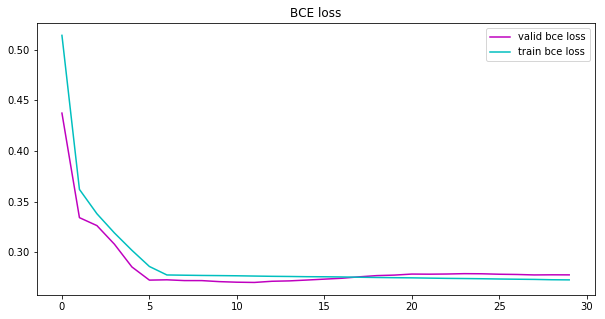

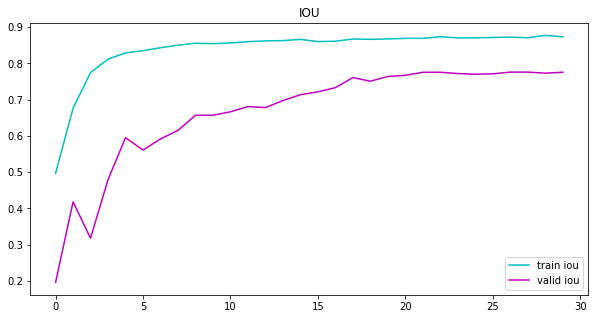

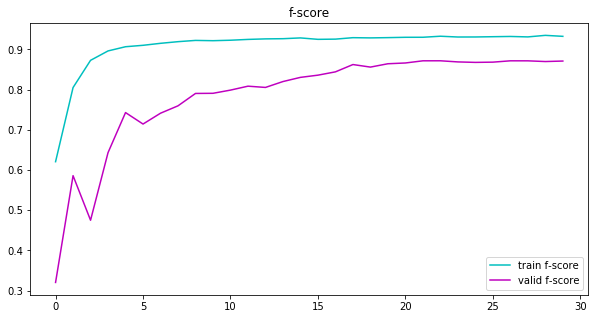

In [31]:


plt.figure(figsize=(10, 5))
plt.title("BCE loss")
plt.plot(val_loss, 'm', label='valid bce loss')
plt.plot(train_loss, 'c', label='train bce loss')
#plt.plot(19, test_bce_loss, 'k', label='test bce loss', marker='o')
plt.legend();

plt.figure(figsize=(10, 5))
plt.title("IOU")
plt.plot(train_iou, 'c', label='train iou')
plt.plot(val_iou, 'm', label='valid iou')
#plt.plot(19, test_iou, 'k', label='test iou', marker='o')
plt.legend();

plt.figure(figsize=(10, 5))
plt.title("f-score")
plt.plot(train_fscore, 'c', label='train f-score')
plt.plot(val_fscore, 'm', label='valid f-score')
#plt.plot(19, test_f_score, 'k', label='test f-score', marker='o')
plt.legend();



In [34]:
!ls


1class				    pyth.ipynb	test19.png  test29.png
1class_augs			    test0.png	test1.png   test2.png
1class_effnet			    test10.png	test20.png  test3.png
3classes			    test11.png	test21.png  test4.png
best_model_eff.pth		    test12.png	test22.png  test5.png
best_model_no_augs.pth		    test13.png	test23.png  test6.png
best_model.pth			    test14.png	test24.png  test7.png
images				    test15.png	test25.png  test8.png
labels				    test16.png	test26.png  test9.png
LV_unet.ipynb			    test17.png	test27.png
ML_biomedicine_practise-master.zip  test18.png	test28.png


In [35]:
!convert -delay 20 -loop 0 *.png 30epochs.gif